### Machine Learning for AES
We will be experimenting with different machine learning based models for essay scoring. They will be trained on style and content based features. The goal is to improve the mean quadratic kappa score. This notebook involves the final results that were included in the paper. The parameters used here were obtained after parameter tuning. The models used were choosen after testing different models. 

In [1]:
from requirements_base import *
#Feature Extraction
from requirements_feature import *
#Keys
from requirements_key import *
#Data Frame 
from requirements_frame import *
#Traing 
from requirements_trainer import *

%matplotlib inline

unable to import 'smart_open.gcs', disabling that module


# 1. Dataset Processing
We will first load the essays from the csv filed provided in the asap data set. These essays will then be divided based on their set number and stored in separate data frames. We will also load the prompt text that is divided in to 4 paragraphs for the source dependent essays. This will be used to generate similarity scores for the essays. 

In [2]:
dataset_path = "../asap-aes/training_set_rel3.tsv"
data = pd.read_csv(dataset_path, sep="\t", encoding="ISO-8859-1", index_col="essay_id")

min_scores = [2, 1, 0, 0, 0, 0, 0, 0]
max_scores = [12, 6, 3, 3, 4, 4, 30, 60]

essay_sets, data_min_scores, data_max_scores = split_in_sets(data, min_scores, max_scores)
set1, set2, set3, set4, set5, set6, set7, set8 = tuple(essay_sets)
data.dropna(axis=1, inplace=True)

data.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
print("All Data:", len(data))
data.head()

Set	Count	Attributes	Score Range	Grade	Type
1	1783	5		[2,12]		8th	PNR
2	1800	8		[1,6]		10th	PNR
3	1726	5		[0,3]		10th	SDR
4	1770	5		[0,3]		10th	SDR
5	1805	5		[0,4]		8th	SDR
6	1800	5		[0,4]		10th	SDR
7	1569	13		[0,30]		7th	PNR
8	723	17		[0,60]		10th	PNR

PNR: Persuasive / Narrative  / Expository 	 SDR: Source Dependent Responses
All Data: 12976


,essay_set,essay,domain1_score
essay_id,,,
1,1,"Dear local newspaper, I think effects computer...",8
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
5,1,"Dear @LOCATION1, I know having computers has a...",8


### Feature Generation Example
Here is an example of features generated for the first essay from the dataset.

In [3]:
pp = pprint.PrettyPrinter(indent=4)

#Featrues
first_essay = data.iloc[0][essay_key]
print(first_essay)
start = time()
_, _, features, extra_features = essay_to_sentences(first_essay, set_no = 1)
end = time()

print("\nExecution time:", end-start)

print("\n\nFeatures: ")
pp.pprint(features)

print("\n\n Extra Features: ")
pp.pprint(extra_features)

Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the economy

### Generation of Learning Data
We will now process the essays one by one and generate the style based features for them. We will also be generating word count vector based similarities with the prompt for the source dependent essays. The dimansionality of these word count vectors is reduced using LSA.

In [4]:
start = time()
X, y = makeDataFrame(data)
end = time()
X_basic = X[feature_keys_list]

print("\nExecution time to make dataframe ", (end-start)/60, " mins\n")

print("All Features:\n")
display(X.head(1))

print("Basic 11 Features:\n")
display(X_basic.head(1))

Generating Style Features
Processed  3000  essays of 12976
Processed  6000  essays of 12976
Processed  9000  essays of 12976
Processed  12000  essays of 12976
Generating Similarity Measures
Processed  3000  essays of 12976
Processed  6000  essays of 12976
Processed  9000  essays of 12976
Processed  12000  essays of 12976

Execution time to make dataframe  4.093943881988525  mins

All Features:



,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
1,1478,350,164,4.325308,16,4.222857,21.875,74,59,34,...,21,84,22,"[dear, local, newspaper, i, think, effects, co...",NaN,NaN,NaN,NaN,NaN,NaN


Basic 11 Features:



,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,l8_word_count,sentences,word_count_vector
1,1478,350,164,4.325308,16,4.222857,21.875,74,59,34,13,"[dear, local, newspaper, i, think, effects, co...",NaN


### Splitting by set number
The main dataframe will be split based on the set number of the essay.

In [5]:
X_sets = []
y_sets = []
essay_sets = [set1, set2, set3, set4, set5, set6, set7, set8]
for set_no in range(8):
    X_set, y_set = X.loc[X.index & essay_sets[set_no].index], y.loc[y.index & essay_sets[set_no].index]
    X_sets.append(X_set)
    y_sets.append(y_set) 

    print("Set", (set_no+1), ":", len(X_set), " essays")   
    display(X_set.head(1))

Set 1 : 1783  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
1,1478,350,164,4.325308,16,4.222857,21.875,74,59,34,...,21,84,22,"[dear, local, newspaper, i, think, effects, co...",NaN,NaN,NaN,NaN,NaN,NaN


Set 2 : 1800  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
2978,2064,486,194,4.695254,19,4.246914,25.578947,114,57,32,...,36,130,30,"[certain, materials, being, removed, from, lib...",NaN,NaN,NaN,NaN,NaN,NaN


Set 3 : 1726  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
5978,209,51,31,2.672345,3,4.098039,17.0,13,10,4,...,0,15,1,"[the, features, of, the, setting, affect, the,...","[8.0, 2.0, 4.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, ...",0.607915,0.547689,0.497195,0.425263,0.591386


Set 4 : 1770  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
8863,243,58,44,2.759669,3,4.189655,19.333333,16,8,4,...,4,10,3,"[the, author, concludes, the, story, with, thi...","[4.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, ...",0.385886,0.430285,0.474141,0.473287,0.496734


Set 5 : 1805  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
11827,570,131,80,3.383123,8,4.351145,16.375,36,21,9,...,3,37,5,"[in, this, memoir, of, narciso, rodriguez, per...","[4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 4.0, ...",0.492161,0.424351,0.513145,0.398284,0.565892


Set 6 : 1800  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
14834,560,123,88,3.330246,6,4.552846,20.5,34,25,17,...,7,35,11,"[there, were, many, obstacles, that, the, buil...","[1.0, 1.0, 2.0, 2.0, 1.0, 14.0, 1.0, 2.0, 4.0,...",0.642754,0.75521,0.732777,0.786687,0.786668


Set 7 : 1569  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
17834,382,94,57,3.113737,3,4.06383,31.333333,24,18,12,...,4,25,2,"[patience, is, when, your, waiting, i, was, pa...",NaN,NaN,NaN,NaN,NaN,NaN


Set 8 : 723  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
20716,2562,708,239,5.15832,39,3.618644,18.153846,104,52,22,...,29,178,41,"[a, long, time, ago, when, i, was, in, third, ...",NaN,NaN,NaN,NaN,NaN,NaN


# 2. Evaluation using style based features
We will be splitting the data in to 5 folds and evaluating the mean quadratic kappa score on those 5 folds. We will also generate scatter plots of the essay score assigned by the graders vs essay id. The points will be coloured based on the score assgined by the model. 

### Evaluation on whole dataset
After testing out different models, we decided to go ahead with linear regression. We trained linear regression with the 11 basic style based features and then used all the 19 style based features. The overall performance improved significantly when all 19 style based features were used.

In [6]:
print("Evaluation using basic 11 features (All Essays)")

classifier = LinearRegression()
np.random.seed(1)
print("Model:", type(classifier).__name__)
k, _ = evaluate(X_basic, y, None, classifier)
print("Mean Quadratic Kappa Score:", k)
print()

print("Evaluation using all features (All Essays)")
classifier = LinearRegression()
np.random.seed(1)
print("Model:", type(classifier).__name__)
k, _ = evaluate(X, y, None, classifier)
print("Mean Quadratic Kappa Score:", k)
print()

Evaluation using basic 11 features (All Essays)
Model: LinearRegression
[ 0.001  mins ] Mean Quadratic Kappa Score: 0.747

Evaluation using all features (All Essays)
Model: LinearRegression
[ 0.001  mins ] Mean Quadratic Kappa Score: 0.8221



### Evaluation on individual sets
We will now compare the performance of individual sets on the basic 11 style based features and all 19 style based features. With addition of more style based features, we see an improvement in performance for sets 1, 2, 7, and 8 which are of type persuasive / narrative  / expository.

In [7]:
print("Mean Quadratic Kappa Score - Basic vs All Features")

for set_no in range(8):
    print("Set", (set_no+1))
    np.random.seed(1)
    classifier = LinearRegression()
    X_basic_set, y_set = X_sets[set_no][feature_keys_list], y_sets[set_no]
    print("Mean Quadratic Kappa (Basic Features):", evaluate(X_basic_set, y_set, None, classifier)[0])
    
    
    np.random.seed(1)
    classifier = LinearRegression()
    X_set, y_set = X_sets[set_no], y_sets[set_no]
    print("Mean Quadratic Kappa (All Features):", evaluate(X_set, y_set, None, classifier)[0])
    
print()

Mean Quadratic Kappa Score - Basic vs All Features
Set 1
[ 0.001  mins ] Mean Quadratic Kappa (Basic Features): 0.8388
[ 0.001  mins ] Mean Quadratic Kappa (All Features): 0.8422
Set 2
[ 0.001  mins ] Mean Quadratic Kappa (Basic Features): 0.6912
[ 0.001  mins ] Mean Quadratic Kappa (All Features): 0.6977
Set 3
[ 0.001  mins ] Mean Quadratic Kappa (Basic Features): 0.6438
[ 0.001  mins ] Mean Quadratic Kappa (All Features): 0.6458
Set 4
[ 0.001  mins ] Mean Quadratic Kappa (Basic Features): 0.6888
[ 0.001  mins ] Mean Quadratic Kappa (All Features): 0.688
Set 5
[ 0.001  mins ] Mean Quadratic Kappa (Basic Features): 0.7777
[ 0.001  mins ] Mean Quadratic Kappa (All Features): 0.7753
Set 6
[ 0.001  mins ] Mean Quadratic Kappa (Basic Features): 0.6626
[ 0.001  mins ] Mean Quadratic Kappa (All Features): 0.6778
Set 7
[ 0.001  mins ] Mean Quadratic Kappa (Basic Features): 0.7303
[ 0.0  mins ] Mean Quadratic Kappa (All Features): 0.7703
Set 8
[ 0.0  mins ] Mean Quadratic Kappa (Basic Features

### Feature performance testing
We next check how the model performs when trained on an individual feature. This gives us an idea of how helpful the features are individually. We then plot the top 4 performing features to see how the essay scores are distributed w.r.t to these features. We see that over all the essays, 3 features we added are in features producing top mean quadratic kappa score.

[ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] 
('punctuations_count', 0.5507)
('sen_count', 0.531)
('adverbs_count', 0.518)
('stopwords_count', 0.513)
('word_count', 0.5116)
('diff_words_count', 0.5029)
('adjective_count', 0.4709)
('char_count', 0.4513)
('word_count_root', 0.4462)
('nouns_count', 0.4457)
('l5_word_count', 0.3274)
('verbs_count', 0.29)
('l6_word_count', 0.2553)
('avg_word_len', 0.2449)
('small_sentence_count', 0.215)
('l7_word_count', 0.164)
('l8_word_count', 0.0696)
('spelling_error_count', 0.0137)
('avg_sen_len', 0.0084)


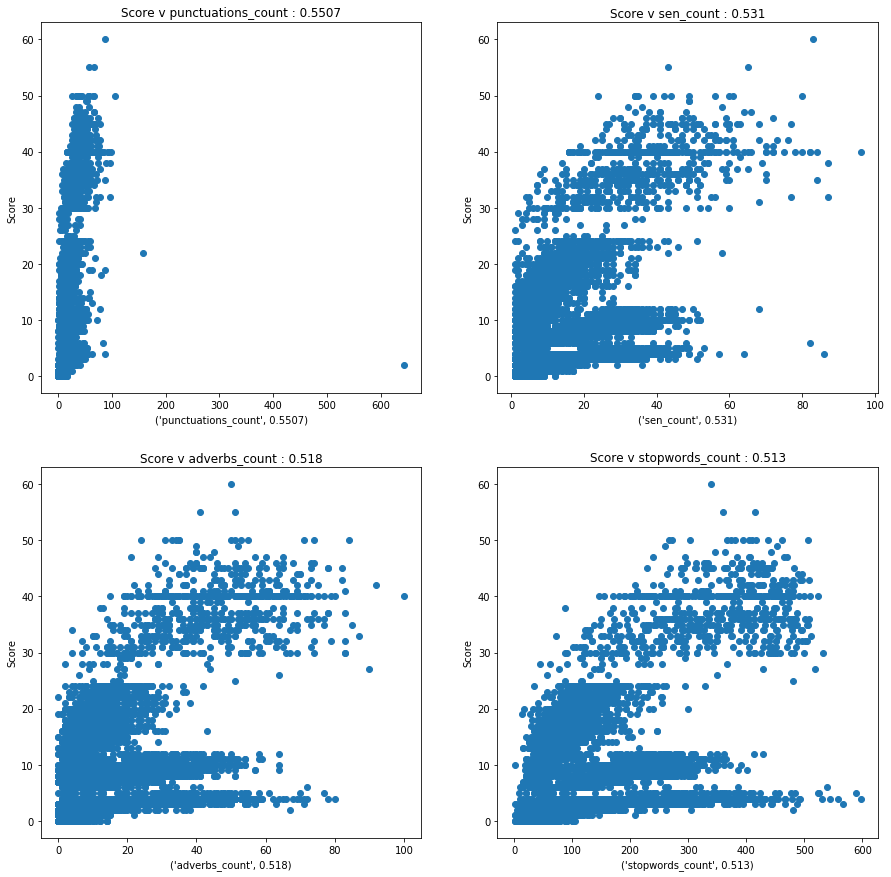

In [8]:
feature_kapps = []
for feature in all_feature_keys_list:
    if feature == sentences_key or feature == word_count_vector_key:
        continue
    np.random.seed(1)
    k_feat, _ = evaluate(X[[feature]+[sentences_key]], y)
    feature_kapps.append((feature, k_feat))
print()
feature_kapps.sort(key = lambda x:  -x[1])
for feature_kappa in feature_kapps:
    print(feature_kappa)
    

top_features = feature_kapps[:4]
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
axs = [ax1, ax2, ax3, ax4]
for i in range(len(top_features)):
    ax = axs[i]
    top_feature = top_features[i]
    ax.scatter(X[[top_feature[0]]],y)
    ax.set_ylabel('Score')
    ax.set_xlabel(top_feature)
    ax.set_title("Score v " + top_feature[0] + " : " + str(top_feature[1]))

fig.savefig('../figs/ScoreVFeature.png', bbox_inches = "tight")

# 3. Evaluation by including content based features
Next we explored the addition of content based features using word2vec and similarity measures. Word2vec model was trained on the training data and then used to get an average vector representation for each essay. Similarity measures were generated using 2 approaches. 
First we used LSA to calculate similairty between word vector representations of essays and paragraphs of the required readings from their question prompts (this was done for set 3, 4, 5, 6 which are of type source dependent responses). We also computed the average word vectors for these prompt paragraphs and calculated thier similarity with the word vector representations of the essays.

### Evaluation on whole dataset
We test the performance on the whole dataset by using all the 19 style based features and the content based feature  generated by average word2vec based essay representation. The performance showed a significent boost over using only style based features.

In [9]:
print("Evaluation on all style based features and word2vec essay representation (All Essays)")

np.random.seed(1)
classifier = LinearRegression()
print("Model:", type(classifier).__name__)
k, _ = evaluate(X, y, None, classifier, wordvec=True, min_count=10)
print("Mean Quadratic Kappa Score:", k)
print()

Evaluation on all style based features and word2vec essay representation (All Essays)
Model: LinearRegression
[ 4.091  mins ] Mean Quadratic Kappa Score: 0.9312



### Evaluation on individual sets 
We will now check the performance of the model using 19 style based features and the content based feature based on average word2vec representation of the essay.

In [10]:
print("Evaluation on all style based features and word2vec essay representation (Individual Sets)")
for set_no in range(8):
    np.random.seed(1)
    X_set, y_set = X_sets[set_no], y_sets[set_no]
    classifier = LinearRegression()
    k, _ = evaluate(X_set, y_set, None, classifier, wordvec=True, wv_size=50,  min_count=10)
    print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", k)
print()

Evaluation on all style based features and word2vec essay representation (Individual Sets)
[ 0.471  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8416
[ 0.497  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6922
[ 0.175  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6458
[ 0.162  mins ] Mean Quadratic Kappa Score - Set 4 : 0.743
[ 0.196  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7993
[ 0.231  mins ] Mean Quadratic Kappa Score - Set 6 : 0.7739
[ 0.214  mins ] Mean Quadratic Kappa Score - Set 7 : 0.8014
[ 0.333  mins ] Mean Quadratic Kappa Score - Set 8 : 0.712



### Evaluation for source dependent responses
We will now evaluate the overall performance of the model using all 19 style based features, average word2vec essay representation and LSA and word2vec based similarity for the readings from prompts. 

#### 1. Evaluation on all source dependend reponses
We will be evluating the model performance using sets 3, 4, 5, and 6. We will compare the performance before adding the content based features and after adding the content based features.

In [11]:
X_src_dep_frames = [X_sets[2], X_sets[3], X_sets[4], X_sets[5]]
y_src_dep_frames = [y_sets[2], y_sets[3], y_sets[4], y_sets[5]]
X_src_dep = pd.concat(X_src_dep_frames)
y_src_dep = pd.concat(y_src_dep_frames)

np.random.seed(1)
classifier = LinearRegression()
k, _ = evaluate(X_src_dep, y_src_dep, None, classifier)
print("Mean Quadratic Kappa Score (All Source Dependent - No Similarity):", k)

np.random.seed(1)
classifier = LinearRegression()
k, _ = evaluate(X_src_dep, y_src_dep, None, classifier, wordvec=True, wv_size=50, min_count=10, lsa=True, wordvec_sim=True)
print("Mean Quadratic Kappa Score (All Source Dependent):", k)

[ 0.001  mins ] Mean Quadratic Kappa Score (All Source Dependent - No Similarity): 0.7569
Mean Quadratic Kappa Score (All Source Dependent): 0.7569


#### 2. Evaluation on individual source dependend reponses sets
We will be evluating the model performance on individual sets 3, 4, 5, and 6. All the content based features will be used.

In [12]:
for set_no in range(4):
    np.random.seed(1)
    X_set, y_set = X_sets[set_no+2], y_sets[set_no+2]  
    classifier = LinearRegression()
    k, _ = evaluate(X_set, y_set, data, classifier, wordvec=True, wv_size=50, min_count=10, lsa=True, wordvec_sim=True)
    print("Mean Quadratic Kappa Score - Set", (set_no+3), ":", k)
print()

[ 1.89  mins ] Mean Quadratic Kappa Score - Set 3 : 0.637
[ 2.096  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7474
[ 1.559  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7956
[ 2.551  mins ] Mean Quadratic Kappa Score - Set 6 : 0.7955



### Further analysis of Set 3
Both set 3 and set 4 have a scoring range of 0-3. The lower range was affecting their performance. In this lower range the corellation could be thrown off even if the rating was a little different. So we decided to try using random forest classifer on these sets to see if the performance improved. The idea was that random forest classifier would be able to give us a better classification than rounding off regression. We used all the 3 content based features 1) Average word2vec, 2) LSA similarity, 3) Average word2vec similarity. 

Random forest helped improve the performance for set 3 but not so much for set 4. Hence we decided to explore the reason behind this. When you see the distribution of scores alloted to different essays, for set 3 the scores are quite skewed. We suspect that this is the reason why regression was producing lower mean quadratic kappa score. For set 4, where the scores are more evenly distributed, we didn't notice any performance improvement.


In [13]:
for set_no in range(2):
    np.random.seed(1)
    X_set, y_set = X_sets[set_no+2], y_sets[set_no+2]
    classifier = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=5, random_state=1)
    k, _ = evaluate(X_set, y_set, data, classifier, wordvec=True, wv_size=50, min_count=10, lsa=True, wordvec_sim=True)
    print("Mean Quadratic Kappa Score - Set", (set_no+3), ":", k)
print()

[ 2.123  mins ] Mean Quadratic Kappa Score - Set 3 : 0.7039
[ 2.319  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7443



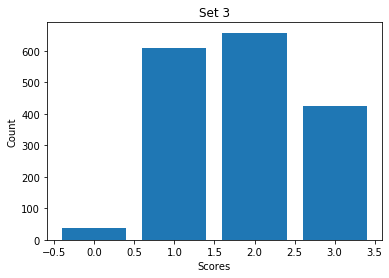

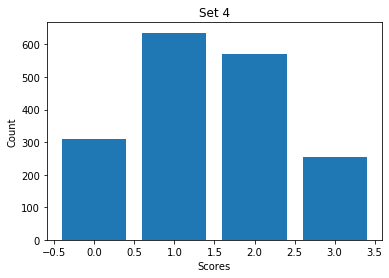

In [14]:
def analyze_score_distribution(scores, set_no):
    fig = plt.figure()
    scores = scores.values.reshape(-1)
    u_scores = dict(zip(list(scores),[list(scores).count(i) for i in list(scores)]))
    u_scores = [u_scores[0], u_scores[1], u_scores[2], u_scores[3]]
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.title("Set "+str(set_no))
    plt.bar([0, 1, 2, 3], u_scores)

analyze_score_distribution(y_sets[2], set_no=3)

analyze_score_distribution(y_sets[3], set_no=4)